In [2]:
import json
import numpy as np
import pandas as pd
import gensim

#import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from num2words import num2words
from pprint import pprint
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
import seaborn as sns

In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

In [3]:

parsed_sites = 'abs_dict.json'

print("Started Reading JSON file")
with open(parsed_sites, "r") as read_file:
    developer = json.load(read_file)
    print("Decoded JSON Data From File")

corpus = developer['abstracts']

# Preprocessing

def convert_lower_case(data):
    return np.char.lower(data)

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def lemming(data):
    lemmatizer = WordNetLemmatizer() 
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return new_text

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text



def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data)
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = lemming(data)
    return data


# Preprocessing
preprocess_abstract = []
for abstract in corpus:
    preprocess_abstract.append(word_tokenize(str(preprocess(abstract))))
    #list of lists of strings (words)




# Build the bigram and trigram models
# Careful: it might be worth creating th bigrams etc before dtemming and lemming
bigram = gensim.models.Phrases(preprocess_abstract) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[preprocess_abstract], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(preprocess_abstract):
    data_processed = []
    for abstract in preprocess_abstract:
        data_processed.append(bigram_mod[abstract])
    return data_processed

bigrams = make_bigrams(preprocess_abstract)

# Create Dictionary
id2word = gensim.corpora.Dictionary(bigrams)

# Create Corpus
texts = bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

"""
# View
print(corpus[:1])
# Human readable format of corpus (term-frequency)
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])
"""


# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

"""
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
"""

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

<>:16: DeprecationWarning: invalid escape sequence \]
<>:16: DeprecationWarning: invalid escape sequence \]
<>:16: DeprecationWarning: invalid escape sequence \]
<ipython-input-3-59bbdd9f7922>:16: DeprecationWarning: invalid escape sequence \]
  symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"


Started Reading JSON file
Decoded JSON Data From File


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.317201  0.088760       1        1  34.048375
1      0.308803  0.177769       2        1  26.868296
6      0.288378 -0.264220       3        1  11.906088
11     0.222154  0.118369       4        1   6.641035
13     0.187347 -0.091244       5        1   5.674248
0     -0.014844 -0.014449       6        1   2.060475
2     -0.037256 -0.065234       7        1   1.839681
9     -0.038261 -0.117438       8        1   1.664025
8     -0.080079 -0.038755       9        1   1.518564
3     -0.038365 -0.092592      10        1   1.518023
17    -0.047469  0.057935      11        1   1.514408
5     -0.090573  0.067152      12        1   1.187335
16    -0.120418  0.022683      13        1   0.780623
14    -0.117667  0.008109      14        1   0.734052
12    -0.102395  0.033328      15        1   0.687828
18    -0.128421  0.020642      16        1   0.391345
19    -0.132803  0.020419      17        1   0.387591
7     -0.128400  0.014552      18        1   0.370086
4     -0.127046  0.026491      19        1   0.197764
10    -0.119885  0.027724      20        1   0.010158, topic_info=              Term        Freq       Total Category  logprob  loglift
122          water  311.000000  311.000000  Default  30.0000  30.0000
251           soil  536.000000  536.000000  Default  29.0000  29.0000
585          plant  335.000000  335.000000  Default  28.0000  28.0000
446          yield  358.000000  358.000000  Default  27.0000  27.0000
254   two_thousand  182.000000  182.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
2262       suspend    0.000991    0.788011  Topic20  -8.8264   2.5158
2260      spectrum    0.000991    1.830988  Topic20  -8.8264   1.6727
2340           sic    0.000991    0.788012  Topic20  -8.8264   2.5158
2259          sorb    0.000991    0.788011  Topic20  -8.8264   2.5158
2236        goals—    0.000991    0.788011  Topic20  -8.8264   2.5158

[1001 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
447       7  0.947798        ,
1069      7  0.985445   ,_nine
520       1  0.489558     abil
520       2  0.195823     abil
520       6  0.097912     abil
...     ...       ...      ...
609      18  0.807037  zea_may
2266     10  0.882072   zeolit
1395      1  0.731038     zero
1395     18  0.243679     zero
517       3  0.985864       °c

[1473 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 2, 7, 12, 14, 1, 3, 10, 9, 4, 18, 6, 17, 15, 13, 19, 20, 8, 5, 11])

In [4]:
# To use the Mallet LDA you must download this:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('two_thousand', 0.061224489795918366),
   ('nutrient', 0.033552404012452436),
   ('farm', 0.030785195434105846),
   ('agricultur', 0.02940159114493255),
   ('year', 0.0287097890003459),
   ('input', 0.024213075060532687),
   ('system', 0.019024558976132824),
   ('larg', 0.015565548253199585),
   ('demand', 0.014873746108612937),
   ('balanc', 0.014527845036319613)]),
 (15,
  [('increas', 0.032281731474688186),
   ('period', 0.02457813646368305),
   ('region', 0.02421129860601614),
   ('time', 0.022377109317681585),
   ('concentr', 0.02090975788701394),
   ('product', 0.020176082171680116),
   ('locat', 0.020176082171680116),
   ('intens', 0.018341892883345562),
   ('averag', 0.01760821716801174),
   ('overal', 0.016507703595011004)]),
 (18,
  [('soil', 0.1393998063891578),
   ('biomass', 0.02420135527589545),
   ('effect', 0.018393030009680542),
   ('nitrogen', 0.015811552113585026),
   ('qualiti', 0.01452081316553727),
   ('observ', 0.01419812842852533),
   ('sampl', 0.013552

In [5]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
# Can take a long time to run.
start=6
limit=30
step=2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bigrams, start=start, limit=limit, step=step)

SyntaxError: positional argument follows keyword argument (<ipython-input-13-3ffcb73488dd>, line 5)

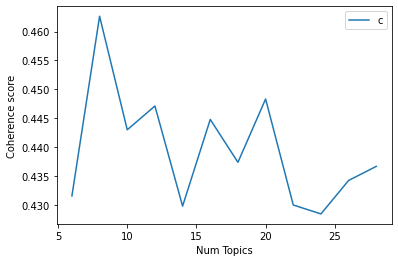

In [11]:
# Show graph

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
print(coherence_values)

[0.43157396307582285, 0.46263787110455074, 0.44300858554782263, 0.4471199758451803, 0.42981042058242697, 0.4447975748186329, 0.4373850803489953, 0.4483284603157475, 0.43000401484674317, 0.4284624813494124, 0.4342444364948314, 0.4366804641021528]


In [6]:
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [10]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=bigrams):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=bigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3945,"farm, farmer, studi, practic, improv, product,...","[peopl, rural_area, south, africa, sa, reli, u..."
1,1,1.0,0.4863,"farm, farmer, studi, practic, improv, product,...","[aim_studi, highlight, import, socioeconom, ps..."
2,2,1.0,0.4188,"farm, farmer, studi, practic, improv, product,...","[urban_agricultur, garden, provid, mani, healt..."
3,3,6.0,0.4636,"agricultur, develop, product, sustain, technol...","[wast, manag, becom, pertin, urban, region, al..."
4,4,0.0,0.1840,"soil, crop, product, increas, plant, qualiti, ...","[plant_growth, regul, pgr, describ, literatur,..."
5,5,4.0,0.2895,"plant, concentr, stress, wheat, condit, genoty...","[dichlorvo, toxic, organophosph, insecticid, u..."
6,6,0.0,0.3984,"soil, crop, product, increas, plant, qualiti, ...","[desert, plant, abl, surviv, harsh, environmen..."
7,7,4.0,0.2260,"plant, concentr, stress, wheat, condit, genoty...","[speci, crest, wheatgrass, agropyron, spp, com..."
8,8,4.0,0.2560,"plant, concentr, stress, wheat, condit, genoty...","[epidemiolog, dynam, follow, virus, protect, h..."
9,9,3.0,0.2905,"view_full, environ, text, system, review, resu...","[steep, slope, main, caus, rollov, incid, agri..."


In [18]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

    
Document_No = list(sent_topics_sorteddf_mallet.index)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

#keep Document_No
sent_topics_sorteddf_mallet["Document_No"] = Document_No

# Show
sent_topics_sorteddf_mallet.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
328,0.0,0.5829,"soil, crop, product, increas, plant, qualiti, ...","[use, straw, soil, amend, well, known, recomme..."
456,1.0,0.5296,"farm, farmer, studi, practic, improv, product,...","[abstract, malnutrit, remain, problem, across,..."
469,2.0,0.5428,"water, two_thousand, increas, irrig, region, a...","[abstract, drain, irrig, marsh, south, west, s..."
421,3.0,0.5694,"view_full, environ, text, system, review, resu...","[abstract, publish, paper, impact, indispens, ..."
425,4.0,0.6526,"plant, concentr, stress, wheat, condit, genoty...","[abstract, effect, miner, nutrit, temperatur, ..."


,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Document_No
0,0.0,0.5829,"soil, crop, product, increas, plant, qualiti, ...","[use, straw, soil, amend, well, known, recomme...",328
1,1.0,0.5296,"farm, farmer, studi, practic, improv, product,...","[abstract, malnutrit, remain, problem, across,...",456
2,2.0,0.5428,"water, two_thousand, increas, irrig, region, a...","[abstract, drain, irrig, marsh, south, west, s...",469
3,3.0,0.5694,"view_full, environ, text, system, review, resu...","[abstract, publish, paper, impact, indispens, ...",421
4,4.0,0.6526,"plant, concentr, stress, wheat, condit, genoty...","[abstract, effect, miner, nutrit, temperatur, ...",425


The use of straw as a soil amendment is a well-known and recommended agronomy practice, but it can lead to negative effects on the soil and crop yield. It has been hypothesized that many problems related to the burying of straw can be overcome by pyrolyzing it. The objective of this study was to determine the effect of straw and its biochar on the biomass production of perennial ryegrass. A pot-based experiment was conducted with three factors: (i) the crop species used as feedstock, (ii) raw or pyrolyzed organic material, and (iii) the rate of organic amendments. The soil in the pots was amended with straw and biochar produced from Miscanthus (Miscanthus × giganteus) or winter wheat (Triticum aestivum L.). After soil amendment application, perennial ryegrass (Lolium perenne L.) seeds were sown. During two years of the experiment, the perennial ryegrass above-ground biomass production and root biomass and morphology parameters were determined. Straw and biochar resulted in higher peren